<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/full_net_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/content
Cloning into 'deepLearning'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 384 (delta 71), reused 49 (delta 21), pack-reused 245
Receiving objects: 100% (384/384), 152.26 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (154/154), done.
Checking out files: 100% (109/109), done.
/content/deepLearning
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
RAM Free: 12.9 GB  | Proc size: 142.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
from common import *
!chmod +x setup.sh
!./setup.sh

Using TensorFlow backend.


--2019-03-14 09:29:15--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.26.197, 107.152.27.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-14 09:29:15--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-14 09:29:15--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcolleg

In [3]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Subtract
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, STNHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
from layers import BilinearInterpolation
from keras.layers import Layer, Lambda

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

def run_sobel(image):
  return tf.image.sobel_edges(image)[:,:,:,0]
      

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights
  
def get_full_model(shape,stn_init=None):  
    #shape = (32, 32, 1)

    init_weights = keras.initializers.he_normal()
    # input 
    inputs = Input(shape)
    
    # denoise network
    depth1  = 32
    conv1_1 = Conv2D(depth1, 1, padding = 'same', kernel_initializer = 'he_normal')(inputs)

    # convolution layers
    conv1_2  = Conv2D(depth1, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_3  = Conv2D(depth1, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_5  = Conv2D(depth1, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_7  = Conv2D(depth1, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_9  = Conv2D(depth1, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_11 = Conv2D(depth1, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)

    # network
    net1 = Subtract()([conv1_1, conv1_2])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_3])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_5])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_7])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_9])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_11])
    net1 = BatchNormalization()(net1)  

    # convolution layers
    depth2 = 16
    conv2_1  = Conv2D(depth2, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv2_2  = Conv2D(depth2, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_3  = Conv2D(depth2, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_5  = Conv2D(depth2, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_7  = Conv2D(depth2, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_9  = Conv2D(depth2, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_11 = Conv2D(depth2, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)

    # network
    net2 = Subtract()([conv2_1, conv2_2])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_3])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_5])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_7])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_9])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_11])
    net2 = BatchNormalization()(net2)  

    # convolution layers
    depth3 = 8
    conv3_1  = Conv2D(depth3, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv3_2  = Conv2D(depth3, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_3  = Conv2D(depth3, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_5  = Conv2D(depth3, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_7  = Conv2D(depth3, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_9  = Conv2D(depth3, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_11 = Conv2D(depth3, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)

    # network
    net3 = Subtract()([conv3_1, conv3_2])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_3])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_5])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_7])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_9])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_11])
    net3 = BatchNormalization()(net3)  

    #net = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(net3)
  
    
    # stn network    
    locnet = MaxPooling2D(pool_size=(2, 2))(net3)
    locnet = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('sigmoid')(locnet)
    weights = get_initial_weights(100)
    locnet = Dense(6, weights=weights)(locnet)
    stn    = BilinearInterpolation(shape[:-1])([net3, locnet])
    
    if stn_init:
      stn.set_weights(stn_init.get_weights())
      
    # sobel
    sobel = Lambda(run_sobel)(net3)
    
    # features in
    l2net = concatenate([ net3, stn , sobel ], axis = -1)
    
    # L2 Net    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 8, padding='valid', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)

    l2net = Reshape((128,))(l2net)
  
    l2net = Model(inputs = inputs, outputs = l2net)
    
    descriptor_model = Sequential()
    descriptor_model.add(l2net)
    
    return descriptor_model

    
  
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_full_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000, batch_size=500)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000, batch_size=500)

Using noisy patches
100%|██████████| 116/116 [00:33<00:00,  2.16it/s]


100%|██████████| 100000/100000 [00:01<00:00, 55199.32it/s]


Using noisy patches
100%|██████████| 116/116 [00:20<00:00,  5.60it/s]


100%|██████████| 10000/10000 [00:00<00:00, 67824.55it/s]


In [5]:
# callbacks
callbacks = [
    #keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/descriptor_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=100, callbacks=callbacks,
                                              verbose=1, validation_data=val_generator)


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
199/200 [============================>.] - ETA: 1s - loss: 0.2769

100%|██████████| 100000/100000 [00:03<00:00, 31198.54it/s]


200/200 [==============================] - 213s 1s/step - loss: 0.2765 - val_loss: 0.2661

Epoch 00001: val_loss improved from inf to 0.26611, saving model to data/descriptor_model.weights.01-0.27.hdf5


 33%|███▎      | 3284/10000 [00:00<00:00, 32382.66it/s]

Epoch 2/100


100%|██████████| 10000/10000 [00:00<00:00, 33754.50it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2049

100%|██████████| 100000/100000 [00:03<00:00, 33007.05it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.2049 - val_loss: 0.2433

Epoch 00002: val_loss improved from 0.26611 to 0.24331, saving model to data/descriptor_model.weights.02-0.24.hdf5
Epoch 3/100
  1/200 [..............................] - ETA: 3:10 - loss: 0.1573

100%|██████████| 10000/10000 [00:00<00:00, 39339.00it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1844

100%|██████████| 100000/100000 [00:02<00:00, 35347.76it/s]


200/200 [==============================] - 200s 1000ms/step - loss: 0.1844 - val_loss: 0.2188

Epoch 00003: val_loss improved from 0.24331 to 0.21879, saving model to data/descriptor_model.weights.03-0.22.hdf5
Epoch 4/100
  1/200 [..............................] - ETA: 3:10 - loss: 0.1874

 39%|███▉      | 3876/10000 [00:00<00:00, 38755.69it/s]

  2/200 [..............................] - ETA: 3:14 - loss: 0.1796

100%|██████████| 10000/10000 [00:00<00:00, 35560.59it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1726

100%|██████████| 100000/100000 [00:03<00:00, 31940.82it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.1726 - val_loss: 0.2055

Epoch 00004: val_loss improved from 0.21879 to 0.20546, saving model to data/descriptor_model.weights.04-0.21.hdf5
Epoch 5/100
  1/200 [..............................] - ETA: 3:16 - loss: 0.1579

 84%|████████▎ | 8354/10000 [00:00<00:00, 39187.75it/s]

  2/200 [..............................] - ETA: 3:17 - loss: 0.1460

100%|██████████| 10000/10000 [00:00<00:00, 36845.99it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1644

100%|██████████| 100000/100000 [00:03<00:00, 31684.38it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1642 - val_loss: 0.2028

Epoch 00005: val_loss improved from 0.20546 to 0.20276, saving model to data/descriptor_model.weights.05-0.20.hdf5
Epoch 6/100
  1/200 [..............................] - ETA: 3:14 - loss: 0.1754

100%|██████████| 10000/10000 [00:00<00:00, 41112.81it/s]

  2/200 [..............................] - ETA: 3:15 - loss: 0.1635

199/200 [============================>.] - ETA: 0s - loss: 0.1574

100%|██████████| 100000/100000 [00:03<00:00, 29649.80it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.1575 - val_loss: 0.1889

Epoch 00006: val_loss improved from 0.20276 to 0.18891, saving model to data/descriptor_model.weights.06-0.19.hdf5
Epoch 7/100
  2/200 [..............................] - ETA: 3:15 - loss: 0.1618

100%|██████████| 10000/10000 [00:00<00:00, 34125.70it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1510

100%|██████████| 100000/100000 [00:03<00:00, 30898.31it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.1510 - val_loss: 0.1812

Epoch 00007: val_loss improved from 0.18891 to 0.18123, saving model to data/descriptor_model.weights.07-0.18.hdf5
Epoch 8/100
  1/200 [..............................] - ETA: 3:08 - loss: 0.1526

100%|██████████| 10000/10000 [00:00<00:00, 38859.39it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1443

100%|██████████| 100000/100000 [00:03<00:00, 31103.76it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.1444 - val_loss: 0.1836

Epoch 00008: val_loss did not improve from 0.18123
Epoch 9/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.1414

100%|██████████| 10000/10000 [00:00<00:00, 34773.05it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1426

100%|██████████| 100000/100000 [00:03<00:00, 31041.81it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1427 - val_loss: 0.1840

Epoch 00009: val_loss did not improve from 0.18123
Epoch 10/100
  1/200 [..............................] - ETA: 3:13 - loss: 0.1348

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:12 - loss: 0.1260

100%|██████████| 10000/10000 [00:00<00:00, 30707.84it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1374

100%|██████████| 100000/100000 [00:02<00:00, 35122.21it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.1375 - val_loss: 0.1715

Epoch 00010: val_loss improved from 0.18123 to 0.17148, saving model to data/descriptor_model.weights.10-0.17.hdf5
Epoch 11/100
  1/200 [..............................] - ETA: 3:12 - loss: 0.1393

 36%|███▌      | 3611/10000 [00:00<00:00, 36103.23it/s]

  2/200 [..............................] - ETA: 3:13 - loss: 0.1321

100%|██████████| 10000/10000 [00:00<00:00, 36916.13it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1348

100%|██████████| 100000/100000 [00:02<00:00, 36752.03it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1347 - val_loss: 0.1691

Epoch 00011: val_loss improved from 0.17148 to 0.16905, saving model to data/descriptor_model.weights.11-0.17.hdf5
Epoch 12/100


100%|██████████| 10000/10000 [00:00<00:00, 28612.62it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1299

100%|██████████| 100000/100000 [00:02<00:00, 36234.90it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1298 - val_loss: 0.1775

Epoch 00012: val_loss did not improve from 0.16905
Epoch 13/100
  2/200 [..............................] - ETA: 3:09 - loss: 0.1274

100%|██████████| 10000/10000 [00:00<00:00, 13131.22it/s]

  3/200 [..............................] - ETA: 3:08 - loss: 0.1246

199/200 [============================>.] - ETA: 0s - loss: 0.1301

100%|██████████| 100000/100000 [00:02<00:00, 37146.84it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1303 - val_loss: 0.1648

Epoch 00013: val_loss improved from 0.16905 to 0.16475, saving model to data/descriptor_model.weights.13-0.16.hdf5
Epoch 14/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.1058

100%|██████████| 10000/10000 [00:00<00:00, 35471.45it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1259

100%|██████████| 100000/100000 [00:02<00:00, 34924.37it/s]


200/200 [==============================] - 198s 992ms/step - loss: 0.1259 - val_loss: 0.1701

Epoch 00014: val_loss did not improve from 0.16475
Epoch 15/100
  2/200 [..............................] - ETA: 3:15 - loss: 0.1150

100%|██████████| 10000/10000 [00:00<00:00, 38478.55it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1240

100%|██████████| 100000/100000 [00:03<00:00, 31673.62it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1241 - val_loss: 0.1556

Epoch 00015: val_loss improved from 0.16475 to 0.15558, saving model to data/descriptor_model.weights.15-0.16.hdf5
Epoch 16/100
  1/200 [..............................] - ETA: 3:12 - loss: 0.1172

100%|██████████| 10000/10000 [00:00<00:00, 38412.97it/s]

  2/200 [..............................] - ETA: 3:14 - loss: 0.1199

199/200 [============================>.] - ETA: 0s - loss: 0.1223

100%|██████████| 100000/100000 [00:03<00:00, 31551.56it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.1223 - val_loss: 0.1582

Epoch 00016: val_loss did not improve from 0.15558
Epoch 17/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0986

100%|██████████| 10000/10000 [00:00<00:00, 37122.14it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1226

100%|██████████| 100000/100000 [00:03<00:00, 31166.08it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1225 - val_loss: 0.1503

Epoch 00017: val_loss improved from 0.15558 to 0.15030, saving model to data/descriptor_model.weights.17-0.15.hdf5
Epoch 18/100
  1/200 [..............................] - ETA: 3:12 - loss: 0.1006

100%|██████████| 10000/10000 [00:00<00:00, 39762.16it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1199

100%|██████████| 100000/100000 [00:03<00:00, 32211.54it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1197 - val_loss: 0.1577

Epoch 00018: val_loss did not improve from 0.15030
Epoch 19/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.1021

100%|██████████| 10000/10000 [00:00<00:00, 36784.69it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1177

100%|██████████| 100000/100000 [00:03<00:00, 30452.02it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1177 - val_loss: 0.1616

Epoch 00019: val_loss did not improve from 0.15030
Epoch 20/100
  2/200 [..............................] - ETA: 3:10 - loss: 0.1103

100%|██████████| 10000/10000 [00:00<00:00, 34509.38it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1153

100%|██████████| 100000/100000 [00:03<00:00, 31271.44it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1154 - val_loss: 0.1515

Epoch 00020: val_loss did not improve from 0.15030
Epoch 21/100
  2/200 [..............................] - ETA: 3:16 - loss: 0.1094

100%|██████████| 10000/10000 [00:00<00:00, 34638.96it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1137

100%|██████████| 100000/100000 [00:03<00:00, 30263.38it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1137 - val_loss: 0.1503

Epoch 00021: val_loss improved from 0.15030 to 0.15025, saving model to data/descriptor_model.weights.21-0.15.hdf5
Epoch 22/100
  2/200 [..............................] - ETA: 3:11 - loss: 0.1064

100%|██████████| 10000/10000 [00:00<00:00, 33532.25it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1119

100%|██████████| 100000/100000 [00:03<00:00, 31082.58it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1120 - val_loss: 0.1553

Epoch 00022: val_loss did not improve from 0.15025
Epoch 23/100
  2/200 [..............................] - ETA: 3:15 - loss: 0.1008

100%|██████████| 10000/10000 [00:00<00:00, 37766.41it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1103

100%|██████████| 100000/100000 [00:03<00:00, 31297.48it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.1103 - val_loss: 0.1608

Epoch 00023: val_loss did not improve from 0.15025
Epoch 24/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.1063

100%|██████████| 10000/10000 [00:00<00:00, 35946.02it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1102

100%|██████████| 100000/100000 [00:03<00:00, 32832.99it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1102 - val_loss: 0.1483

Epoch 00024: val_loss improved from 0.15025 to 0.14829, saving model to data/descriptor_model.weights.24-0.15.hdf5
Epoch 25/100
  1/200 [..............................] - ETA: 3:15 - loss: 0.1324

100%|██████████| 10000/10000 [00:00<00:00, 39012.35it/s]

  2/200 [..............................] - ETA: 3:13 - loss: 0.1075

199/200 [============================>.] - ETA: 0s - loss: 0.1092

100%|██████████| 100000/100000 [00:03<00:00, 29743.75it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1091 - val_loss: 0.1510

Epoch 00025: val_loss did not improve from 0.14829
Epoch 26/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.1067

100%|██████████| 10000/10000 [00:00<00:00, 38995.49it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1097

100%|██████████| 100000/100000 [00:03<00:00, 30666.36it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1098 - val_loss: 0.1473

Epoch 00026: val_loss improved from 0.14829 to 0.14729, saving model to data/descriptor_model.weights.26-0.15.hdf5
Epoch 27/100
  1/200 [..............................] - ETA: 3:21 - loss: 0.1249

 42%|████▏     | 4228/10000 [00:00<00:00, 42271.57it/s]

  2/200 [..............................] - ETA: 3:18 - loss: 0.1225

100%|██████████| 10000/10000 [00:00<00:00, 36263.61it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1043

100%|██████████| 100000/100000 [00:03<00:00, 30619.71it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.1043 - val_loss: 0.1441

Epoch 00027: val_loss improved from 0.14729 to 0.14412, saving model to data/descriptor_model.weights.27-0.14.hdf5
Epoch 28/100
  1/200 [..............................] - ETA: 3:12 - loss: 0.1069

100%|██████████| 10000/10000 [00:00<00:00, 35957.95it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1053

100%|██████████| 100000/100000 [00:03<00:00, 31024.76it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.1054 - val_loss: 0.1445

Epoch 00028: val_loss did not improve from 0.14412
Epoch 29/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.1066

100%|██████████| 10000/10000 [00:00<00:00, 31314.61it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1028

100%|██████████| 100000/100000 [00:03<00:00, 31496.47it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.1029 - val_loss: 0.1562

Epoch 00029: val_loss did not improve from 0.14412
Epoch 30/100
  1/200 [..............................] - ETA: 3:16 - loss: 0.1034

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:14 - loss: 0.1080

100%|██████████| 10000/10000 [00:00<00:00, 31611.58it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1034

100%|██████████| 100000/100000 [00:03<00:00, 31509.79it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.1034 - val_loss: 0.1360

Epoch 00030: val_loss improved from 0.14412 to 0.13605, saving model to data/descriptor_model.weights.30-0.14.hdf5
Epoch 31/100
  1/200 [..............................] - ETA: 3:15 - loss: 0.1032

100%|██████████| 10000/10000 [00:00<00:00, 37779.48it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1016

100%|██████████| 100000/100000 [00:03<00:00, 31785.59it/s]


200/200 [==============================] - 200s 999ms/step - loss: 0.1017 - val_loss: 0.1338

Epoch 00031: val_loss improved from 0.13605 to 0.13378, saving model to data/descriptor_model.weights.31-0.13.hdf5
Epoch 32/100


100%|██████████| 10000/10000 [00:00<00:00, 40617.84it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0993

100%|██████████| 100000/100000 [00:02<00:00, 37081.18it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.0993 - val_loss: 0.1347

Epoch 00032: val_loss did not improve from 0.13378
Epoch 33/100
  2/200 [..............................] - ETA: 3:11 - loss: 0.0872

100%|██████████| 10000/10000 [00:00<00:00, 39868.26it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0996

100%|██████████| 100000/100000 [00:03<00:00, 31387.52it/s]


200/200 [==============================] - 200s 999ms/step - loss: 0.0998 - val_loss: 0.1353

Epoch 00033: val_loss did not improve from 0.13378
Epoch 34/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.1186

100%|██████████| 10000/10000 [00:00<00:00, 37291.25it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0998

100%|██████████| 100000/100000 [00:03<00:00, 31246.27it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.0997 - val_loss: 0.1372

Epoch 00034: val_loss did not improve from 0.13378
Epoch 35/100
  1/200 [..............................] - ETA: 3:25 - loss: 0.0924

 42%|████▏     | 4176/10000 [00:00<00:00, 41759.44it/s]

  2/200 [..............................] - ETA: 3:26 - loss: 0.0921

100%|██████████| 10000/10000 [00:00<00:00, 38708.87it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1002

100%|██████████| 100000/100000 [00:03<00:00, 31250.29it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.1002 - val_loss: 0.1426

Epoch 00035: val_loss did not improve from 0.13378
Epoch 36/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.1043

100%|██████████| 10000/10000 [00:00<00:00, 39554.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0995

100%|██████████| 100000/100000 [00:03<00:00, 31663.78it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.0995 - val_loss: 0.1304

Epoch 00036: val_loss improved from 0.13378 to 0.13045, saving model to data/descriptor_model.weights.36-0.13.hdf5
Epoch 37/100
  1/200 [..............................] - ETA: 3:11 - loss: 0.0976

100%|██████████| 10000/10000 [00:00<00:00, 39251.49it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0966

100%|██████████| 100000/100000 [00:03<00:00, 29732.39it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.0966 - val_loss: 0.1294

Epoch 00037: val_loss improved from 0.13045 to 0.12941, saving model to data/descriptor_model.weights.37-0.13.hdf5
Epoch 38/100
  2/200 [..............................] - ETA: 3:10 - loss: 0.0832

100%|██████████| 10000/10000 [00:00<00:00, 35404.53it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0972

100%|██████████| 100000/100000 [00:03<00:00, 31034.61it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0971 - val_loss: 0.1281

Epoch 00038: val_loss improved from 0.12941 to 0.12814, saving model to data/descriptor_model.weights.38-0.13.hdf5
Epoch 39/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0942

100%|██████████| 10000/10000 [00:00<00:00, 37155.94it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0964

100%|██████████| 100000/100000 [00:03<00:00, 31649.99it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0964 - val_loss: 0.1288

Epoch 00039: val_loss did not improve from 0.12814
Epoch 40/100
  2/200 [..............................] - ETA: 3:17 - loss: 0.0961

100%|██████████| 10000/10000 [00:00<00:00, 34141.84it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0938

100%|██████████| 100000/100000 [00:03<00:00, 30293.41it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.0939 - val_loss: 0.1266

Epoch 00040: val_loss improved from 0.12814 to 0.12658, saving model to data/descriptor_model.weights.40-0.13.hdf5
Epoch 41/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0885

100%|██████████| 10000/10000 [00:00<00:00, 34976.87it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0943

100%|██████████| 100000/100000 [00:03<00:00, 31210.16it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0942 - val_loss: 0.1317

Epoch 00041: val_loss did not improve from 0.12658
Epoch 42/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.1052

100%|██████████| 10000/10000 [00:00<00:00, 35006.50it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0944

100%|██████████| 100000/100000 [00:03<00:00, 32325.29it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0944 - val_loss: 0.1284

Epoch 00042: val_loss did not improve from 0.12658
Epoch 43/100
  1/200 [..............................] - ETA: 3:13 - loss: 0.0868

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:12 - loss: 0.0852

100%|██████████| 10000/10000 [00:00<00:00, 38085.93it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0937

100%|██████████| 100000/100000 [00:03<00:00, 31599.33it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.0937 - val_loss: 0.1304

Epoch 00043: val_loss did not improve from 0.12658
Epoch 44/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0860

100%|██████████| 10000/10000 [00:00<00:00, 36362.49it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0926

100%|██████████| 100000/100000 [00:02<00:00, 36600.60it/s]


200/200 [==============================] - 200s 999ms/step - loss: 0.0926 - val_loss: 0.1210

Epoch 00044: val_loss improved from 0.12658 to 0.12101, saving model to data/descriptor_model.weights.44-0.12.hdf5
Epoch 45/100
  1/200 [..............................] - ETA: 3:08 - loss: 0.0924

100%|██████████| 10000/10000 [00:00<00:00, 40849.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0914

100%|██████████| 100000/100000 [00:02<00:00, 35717.06it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.0913 - val_loss: 0.1378

Epoch 00045: val_loss did not improve from 0.12101
Epoch 46/100
  1/200 [..............................] - ETA: 3:07 - loss: 0.0898

 41%|████      | 4090/10000 [00:00<00:00, 40897.70it/s]

  2/200 [..............................] - ETA: 3:09 - loss: 0.0862

100%|██████████| 10000/10000 [00:00<00:00, 40957.80it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0927

100%|██████████| 100000/100000 [00:02<00:00, 35125.73it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0927 - val_loss: 0.1219

Epoch 00046: val_loss did not improve from 0.12101
Epoch 47/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.1108

100%|██████████| 10000/10000 [00:00<00:00, 37470.09it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0926

100%|██████████| 100000/100000 [00:02<00:00, 35941.70it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.0925 - val_loss: 0.1307

Epoch 00047: val_loss did not improve from 0.12101
Epoch 48/100
  2/200 [..............................] - ETA: 3:39 - loss: 0.0994

100%|██████████| 10000/10000 [00:00<00:00, 39624.64it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0903

100%|██████████| 100000/100000 [00:02<00:00, 35648.09it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0903 - val_loss: 0.1255

Epoch 00048: val_loss did not improve from 0.12101
Epoch 49/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.0784

100%|██████████| 10000/10000 [00:00<00:00, 41146.93it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0897

100%|██████████| 100000/100000 [00:03<00:00, 31819.35it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.0898 - val_loss: 0.1249

Epoch 00049: val_loss did not improve from 0.12101
Epoch 50/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0996

100%|██████████| 10000/10000 [00:00<00:00, 35896.86it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0891

100%|██████████| 100000/100000 [00:03<00:00, 31465.42it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0890 - val_loss: 0.1218

Epoch 00050: val_loss did not improve from 0.12101
Epoch 51/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.0977

100%|██████████| 10000/10000 [00:00<00:00, 35360.65it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0891

100%|██████████| 100000/100000 [00:03<00:00, 31313.06it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.0892 - val_loss: 0.1275

Epoch 00051: val_loss did not improve from 0.12101
Epoch 52/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0978

100%|██████████| 10000/10000 [00:00<00:00, 37430.66it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0872

100%|██████████| 100000/100000 [00:03<00:00, 32031.97it/s]


200/200 [==============================] - 199s 993ms/step - loss: 0.0873 - val_loss: 0.1137

Epoch 00052: val_loss improved from 0.12101 to 0.11368, saving model to data/descriptor_model.weights.52-0.11.hdf5
Epoch 53/100
  1/200 [..............................] - ETA: 3:12 - loss: 0.0915

100%|██████████| 10000/10000 [00:00<00:00, 38543.79it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0884

100%|██████████| 100000/100000 [00:03<00:00, 30045.80it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.0885 - val_loss: 0.1156

Epoch 00053: val_loss did not improve from 0.11368
Epoch 54/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0771

100%|██████████| 10000/10000 [00:00<00:00, 34417.65it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0870

100%|██████████| 100000/100000 [00:03<00:00, 31550.18it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0872 - val_loss: 0.1214

Epoch 00054: val_loss did not improve from 0.11368
Epoch 55/100
  1/200 [..............................] - ETA: 3:14 - loss: 0.0829

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:15 - loss: 0.0686

100%|██████████| 10000/10000 [00:00<00:00, 35834.94it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0867

100%|██████████| 100000/100000 [00:03<00:00, 28317.48it/s]


200/200 [==============================] - 200s 1000ms/step - loss: 0.0869 - val_loss: 0.1201

Epoch 00055: val_loss did not improve from 0.11368
Epoch 56/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.0869

100%|██████████| 10000/10000 [00:00<00:00, 37979.81it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0869

100%|██████████| 100000/100000 [00:03<00:00, 30571.37it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0870 - val_loss: 0.1241

Epoch 00056: val_loss did not improve from 0.11368
Epoch 57/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0864

100%|██████████| 10000/10000 [00:00<00:00, 36797.01it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0896

100%|██████████| 100000/100000 [00:03<00:00, 31580.12it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0894 - val_loss: 0.1150

Epoch 00057: val_loss did not improve from 0.11368
Epoch 58/100
  2/200 [..............................] - ETA: 3:18 - loss: 0.0930

100%|██████████| 10000/10000 [00:00<00:00, 36823.31it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0872

100%|██████████| 100000/100000 [00:02<00:00, 35585.47it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.0873 - val_loss: 0.1154

Epoch 00058: val_loss did not improve from 0.11368
Epoch 59/100
  2/200 [..............................] - ETA: 3:10 - loss: 0.0976

100%|██████████| 10000/10000 [00:00<00:00, 39716.00it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0848

100%|██████████| 100000/100000 [00:03<00:00, 30721.76it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0848 - val_loss: 0.1213

Epoch 00059: val_loss did not improve from 0.11368
Epoch 60/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0894

100%|██████████| 10000/10000 [00:00<00:00, 35815.23it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0857

100%|██████████| 100000/100000 [00:03<00:00, 30480.57it/s]


200/200 [==============================] - 200s 999ms/step - loss: 0.0857 - val_loss: 0.1099

Epoch 00060: val_loss improved from 0.11368 to 0.10992, saving model to data/descriptor_model.weights.60-0.11.hdf5
Epoch 61/100
  1/200 [..............................] - ETA: 3:13 - loss: 0.0984

100%|██████████| 10000/10000 [00:00<00:00, 38939.16it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0861

100%|██████████| 100000/100000 [00:03<00:00, 30947.08it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0861 - val_loss: 0.1133

Epoch 00061: val_loss did not improve from 0.10992
Epoch 62/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.0713

100%|██████████| 10000/10000 [00:00<00:00, 34715.71it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0847

100%|██████████| 100000/100000 [00:03<00:00, 31671.90it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.0847 - val_loss: 0.1176

Epoch 00062: val_loss did not improve from 0.10992
Epoch 63/100
  1/200 [..............................] - ETA: 3:10 - loss: 0.0869

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:12 - loss: 0.0916

100%|██████████| 10000/10000 [00:00<00:00, 40319.34it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0825

100%|██████████| 100000/100000 [00:03<00:00, 31018.06it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.0824 - val_loss: 0.1174

Epoch 00063: val_loss did not improve from 0.10992
Epoch 64/100
  2/200 [..............................] - ETA: 3:11 - loss: 0.0790

100%|██████████| 10000/10000 [00:00<00:00, 35256.21it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0828

100%|██████████| 100000/100000 [00:03<00:00, 31155.01it/s]


200/200 [==============================] - 199s 995ms/step - loss: 0.0830 - val_loss: 0.1141

Epoch 00064: val_loss did not improve from 0.10992
Epoch 65/100
  1/200 [..............................] - ETA: 5:02 - loss: 0.0660

100%|██████████| 10000/10000 [00:00<00:00, 40013.62it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0823

100%|██████████| 100000/100000 [00:03<00:00, 31130.86it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.0823 - val_loss: 0.1121

Epoch 00065: val_loss did not improve from 0.10992
Epoch 66/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0882

100%|██████████| 10000/10000 [00:00<00:00, 35339.77it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0809

100%|██████████| 100000/100000 [00:03<00:00, 33099.80it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.0810 - val_loss: 0.1141

Epoch 00066: val_loss did not improve from 0.10992
Epoch 67/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.1015

100%|██████████| 10000/10000 [00:00<00:00, 37261.54it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0841

100%|██████████| 100000/100000 [00:03<00:00, 29439.47it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0841 - val_loss: 0.1127

Epoch 00067: val_loss did not improve from 0.10992
Epoch 68/100
  2/200 [..............................] - ETA: 3:11 - loss: 0.0654

100%|██████████| 10000/10000 [00:00<00:00, 31664.40it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0828

100%|██████████| 100000/100000 [00:03<00:00, 29061.99it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0828 - val_loss: 0.1094

Epoch 00068: val_loss improved from 0.10992 to 0.10937, saving model to data/descriptor_model.weights.68-0.11.hdf5
Epoch 69/100
  2/200 [..............................] - ETA: 3:19 - loss: 0.0867

100%|██████████| 10000/10000 [00:00<00:00, 32040.02it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0808

100%|██████████| 100000/100000 [00:03<00:00, 31498.24it/s]


200/200 [==============================] - 200s 1000ms/step - loss: 0.0808 - val_loss: 0.1142

Epoch 00069: val_loss did not improve from 0.10937
Epoch 70/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0948

100%|██████████| 10000/10000 [00:00<00:00, 35116.26it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0816

100%|██████████| 100000/100000 [00:03<00:00, 31941.26it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0818 - val_loss: 0.1155

Epoch 00070: val_loss did not improve from 0.10937
Epoch 71/100
  2/200 [..............................] - ETA: 3:17 - loss: 0.0854

100%|██████████| 10000/10000 [00:00<00:00, 30300.04it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0830

100%|██████████| 100000/100000 [00:03<00:00, 30332.06it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0830 - val_loss: 0.1131

Epoch 00071: val_loss did not improve from 0.10937
Epoch 72/100


 68%|██████▊   | 6839/10000 [00:00<00:00, 6124.55it/s] 

  1/200 [..............................] - ETA: 7:47 - loss: 0.1008

100%|██████████| 10000/10000 [00:00<00:00, 10942.79it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0815

100%|██████████| 100000/100000 [00:03<00:00, 32652.35it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0814 - val_loss: 0.1129

Epoch 00072: val_loss did not improve from 0.10937
Epoch 73/100
  2/200 [..............................] - ETA: 3:11 - loss: 0.0731

  0%|          | 0/10000 [00:00<?, ?it/s]

  3/200 [..............................] - ETA: 3:13 - loss: 0.0751

100%|██████████| 10000/10000 [00:00<00:00, 27741.50it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0796

100%|██████████| 100000/100000 [00:02<00:00, 35822.96it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0795 - val_loss: 0.1224

Epoch 00073: val_loss did not improve from 0.10937
Epoch 74/100
  2/200 [..............................] - ETA: 3:15 - loss: 0.0993

100%|██████████| 10000/10000 [00:00<00:00, 36906.75it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0799

100%|██████████| 100000/100000 [00:03<00:00, 33044.89it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0798 - val_loss: 0.1056

Epoch 00074: val_loss improved from 0.10937 to 0.10557, saving model to data/descriptor_model.weights.74-0.11.hdf5
Epoch 75/100
  1/200 [..............................] - ETA: 3:14 - loss: 0.0925

100%|██████████| 10000/10000 [00:00<00:00, 41052.65it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0818

100%|██████████| 100000/100000 [00:02<00:00, 34407.96it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0818 - val_loss: 0.1330

Epoch 00075: val_loss did not improve from 0.10557
Epoch 76/100
  1/200 [..............................] - ETA: 3:17 - loss: 0.0979

100%|██████████| 10000/10000 [00:00<00:00, 40478.84it/s]

  2/200 [..............................] - ETA: 3:20 - loss: 0.0900

199/200 [============================>.] - ETA: 0s - loss: 0.0803

100%|██████████| 100000/100000 [00:03<00:00, 32952.82it/s]


200/200 [==============================] - 202s 1s/step - loss: 0.0802 - val_loss: 0.1147

Epoch 00076: val_loss did not improve from 0.10557
Epoch 77/100
  1/200 [..............................] - ETA: 3:30 - loss: 0.0804

100%|██████████| 10000/10000 [00:00<00:00, 39634.38it/s]

  2/200 [..............................] - ETA: 3:26 - loss: 0.0802

199/200 [============================>.] - ETA: 0s - loss: 0.0773

100%|██████████| 100000/100000 [00:03<00:00, 28776.49it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0773 - val_loss: 0.1209

Epoch 00077: val_loss did not improve from 0.10557
Epoch 78/100


 36%|███▌      | 3600/10000 [00:00<00:00, 35998.23it/s]

  1/200 [..............................] - ETA: 3:28 - loss: 0.0798

100%|██████████| 10000/10000 [00:00<00:00, 33459.86it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0779

100%|██████████| 100000/100000 [00:02<00:00, 33540.25it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0779 - val_loss: 0.1361

Epoch 00078: val_loss did not improve from 0.10557
Epoch 79/100
  1/200 [..............................] - ETA: 3:17 - loss: 0.0979

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:17 - loss: 0.0893

100%|██████████| 10000/10000 [00:00<00:00, 37173.56it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0783

100%|██████████| 100000/100000 [00:03<00:00, 32218.85it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0783 - val_loss: 0.1095

Epoch 00079: val_loss did not improve from 0.10557
Epoch 80/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0897

100%|██████████| 10000/10000 [00:00<00:00, 39103.72it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0782

100%|██████████| 100000/100000 [00:03<00:00, 31215.46it/s]


200/200 [==============================] - 200s 999ms/step - loss: 0.0781 - val_loss: 0.1085

Epoch 00080: val_loss did not improve from 0.10557
Epoch 81/100
  1/200 [..............................] - ETA: 3:24 - loss: 0.0850

 75%|███████▌  | 7503/10000 [00:00<00:00, 36559.11it/s]

  2/200 [..............................] - ETA: 3:23 - loss: 0.0824

100%|██████████| 10000/10000 [00:00<00:00, 39084.37it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0780

100%|██████████| 100000/100000 [00:03<00:00, 30867.45it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0780 - val_loss: 0.1121

Epoch 00081: val_loss did not improve from 0.10557
Epoch 82/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0636

100%|██████████| 10000/10000 [00:00<00:00, 37882.49it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0777

100%|██████████| 100000/100000 [00:03<00:00, 31394.78it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0776 - val_loss: 0.1113

Epoch 00082: val_loss did not improve from 0.10557
Epoch 83/100
  1/200 [..............................] - ETA: 3:13 - loss: 0.0832

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:15 - loss: 0.0824

100%|██████████| 10000/10000 [00:00<00:00, 33508.35it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0784

100%|██████████| 100000/100000 [00:03<00:00, 32255.93it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0784 - val_loss: 0.1175

Epoch 00083: val_loss did not improve from 0.10557
Epoch 84/100
  1/200 [..............................] - ETA: 3:11 - loss: 0.0702

100%|██████████| 10000/10000 [00:00<00:00, 34706.01it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0773

100%|██████████| 100000/100000 [00:02<00:00, 35927.47it/s]


200/200 [==============================] - 200s 1000ms/step - loss: 0.0773 - val_loss: 0.1201

Epoch 00084: val_loss did not improve from 0.10557
Epoch 85/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0744

100%|██████████| 10000/10000 [00:00<00:00, 37823.08it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0773

100%|██████████| 100000/100000 [00:03<00:00, 30230.59it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0771 - val_loss: 0.1100

Epoch 00085: val_loss did not improve from 0.10557
Epoch 86/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0706

100%|██████████| 10000/10000 [00:00<00:00, 39745.51it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0767

100%|██████████| 100000/100000 [00:03<00:00, 30941.62it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0767 - val_loss: 0.1122

Epoch 00086: val_loss did not improve from 0.10557
Epoch 87/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0730

100%|██████████| 10000/10000 [00:00<00:00, 35002.94it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0770

100%|██████████| 100000/100000 [00:03<00:00, 30189.21it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0770 - val_loss: 0.1111

Epoch 00087: val_loss did not improve from 0.10557
Epoch 88/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0645

100%|██████████| 10000/10000 [00:00<00:00, 34191.29it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0766

100%|██████████| 100000/100000 [00:03<00:00, 29854.77it/s]


200/200 [==============================] - 200s 1s/step - loss: 0.0767 - val_loss: 0.1130

Epoch 00088: val_loss did not improve from 0.10557
Epoch 89/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.0866

100%|██████████| 10000/10000 [00:00<00:00, 40288.71it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0772

100%|██████████| 100000/100000 [00:03<00:00, 31112.35it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0772 - val_loss: 0.1141

Epoch 00089: val_loss did not improve from 0.10557
Epoch 90/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.0871

100%|██████████| 10000/10000 [00:00<00:00, 34608.38it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0769

100%|██████████| 100000/100000 [00:03<00:00, 31366.93it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0769 - val_loss: 0.1066

Epoch 00090: val_loss did not improve from 0.10557
Epoch 91/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0757

100%|██████████| 10000/10000 [00:00<00:00, 38421.94it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0769

100%|██████████| 100000/100000 [00:03<00:00, 30511.17it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0769 - val_loss: 0.1148

Epoch 00091: val_loss did not improve from 0.10557
Epoch 92/100
  2/200 [..............................] - ETA: 3:13 - loss: 0.0798

100%|██████████| 10000/10000 [00:00<00:00, 35809.58it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0760

100%|██████████| 100000/100000 [00:03<00:00, 30599.12it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0762 - val_loss: 0.1073

Epoch 00092: val_loss did not improve from 0.10557
Epoch 93/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0584

100%|██████████| 10000/10000 [00:00<00:00, 36572.45it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0755

100%|██████████| 100000/100000 [00:03<00:00, 31737.08it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0754 - val_loss: 0.1051

Epoch 00093: val_loss improved from 0.10557 to 0.10512, saving model to data/descriptor_model.weights.93-0.11.hdf5
Epoch 94/100
  1/200 [..............................] - ETA: 3:12 - loss: 0.0870

100%|██████████| 10000/10000 [00:00<00:00, 39404.67it/s]

  2/200 [..............................] - ETA: 3:16 - loss: 0.0851

199/200 [============================>.] - ETA: 0s - loss: 0.0750

100%|██████████| 100000/100000 [00:03<00:00, 30714.45it/s]


200/200 [==============================] - 199s 997ms/step - loss: 0.0750 - val_loss: 0.1155

Epoch 00094: val_loss did not improve from 0.10512
Epoch 95/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.0822

100%|██████████| 10000/10000 [00:00<00:00, 32567.43it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0744

100%|██████████| 100000/100000 [00:03<00:00, 31105.41it/s]


200/200 [==============================] - 200s 999ms/step - loss: 0.0745 - val_loss: 0.1143

Epoch 00095: val_loss did not improve from 0.10512
Epoch 96/100
  1/200 [..............................] - ETA: 3:12 - loss: 0.0729

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:12 - loss: 0.0619

100%|██████████| 10000/10000 [00:00<00:00, 32219.66it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0733

100%|██████████| 100000/100000 [00:03<00:00, 31333.19it/s]


200/200 [==============================] - 201s 1s/step - loss: 0.0732 - val_loss: 0.1123

Epoch 00096: val_loss did not improve from 0.10512
Epoch 97/100
  2/200 [..............................] - ETA: 3:16 - loss: 0.0801

100%|██████████| 10000/10000 [00:00<00:00, 32169.40it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0753

100%|██████████| 100000/100000 [00:03<00:00, 30630.08it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.0753 - val_loss: 0.1037

Epoch 00097: val_loss improved from 0.10512 to 0.10366, saving model to data/descriptor_model.weights.97-0.10.hdf5
Epoch 98/100
  2/200 [..............................] - ETA: 3:12 - loss: 0.0669

100%|██████████| 10000/10000 [00:00<00:00, 35455.44it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0755

100%|██████████| 100000/100000 [00:02<00:00, 37207.35it/s]


200/200 [==============================] - 199s 994ms/step - loss: 0.0755 - val_loss: 0.1040

Epoch 00098: val_loss did not improve from 0.10366
Epoch 99/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.0994

100%|██████████| 10000/10000 [00:00<00:00, 39813.80it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0734

100%|██████████| 100000/100000 [00:03<00:00, 31067.56it/s]


200/200 [==============================] - 200s 998ms/step - loss: 0.0733 - val_loss: 0.1113

Epoch 00099: val_loss did not improve from 0.10366
Epoch 100/100
  2/200 [..............................] - ETA: 3:15 - loss: 0.0758

100%|██████████| 10000/10000 [00:00<00:00, 36532.82it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0738

100%|██████████| 100000/100000 [00:03<00:00, 30698.64it/s]


200/200 [==============================] - 199s 996ms/step - loss: 0.0738 - val_loss: 0.1037

Epoch 00100: val_loss improved from 0.10366 to 0.10365, saving model to data/descriptor_model.weights.100-0.10.hdf5


100%|██████████| 10000/10000 [00:00<00:00, 67140.88it/s]


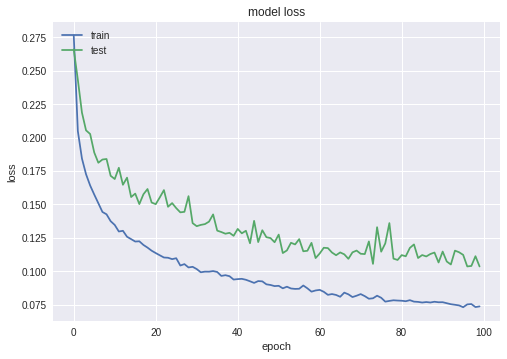

In [7]:

plt.plot(descriptor_history.history['loss'])
plt.plot(descriptor_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

np.save('data/net_loss.npy', np.array(descriptor_history.history['loss']))
np.save('data/net_val_loss.npy', np.array(descriptor_history.history['val_loss']))

In [8]:
from keras.models import load_model
from get_data import get_data
%cd hpatches-benchmark
!git pull 
%cd ..
!mkdir -p results

generate_desc_csv(descriptor_model, seqs_test, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

/content/deepLearning/hpatches-benchmark
Already up to date.
/content/deepLearning


100%|██████████| 40/40 [07:18<00:00,  7.56s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:35<00:00, 10516.58it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:35<00:00, 10459.56it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:33<00:00, 10668.07it/s]
>> Verification task finished in 293 secs  
Verification task results:
Mean Average Precision is 0.847060

>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:11<00:00,  4.34s/it]
>> Matching task finished in 131 secs  
Matching task results:
Mean Average Precision is 0.263945



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc